In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
from common import (ConditionalFlowMatchingTrainer, EulerSimulator, Gaussian,
                    GaussianConditionalProbabilityPath, GaussianMixture,
                    LearnedVectorFieldODE, LinearAlpha, MLPVectorField,
                    SquareRootBeta, imshow_density)
from matplotlib import pyplot as plt

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Constants for the duration of our use of Gaussian conditional probability paths, to avoid polluting the namespace...
PARAMS = {
    "scale": 15.0,
    "target_scale": 10.0,
    "target_std": 1.0,
}

p_simple = Gaussian.isotropic(dim=2, std=1.0).to(device)
p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device)

In [14]:
# Construct conditional probability path
path = GaussianConditionalProbabilityPath(
    p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device),
    alpha = LinearAlpha(),
    beta = SquareRootBeta()
).to(device)

# Construct learnable vector field
flow_model = MLPVectorField(dim=2, hiddens=[64,64,64,64])

# Construct trainer
trainer = ConditionalFlowMatchingTrainer(path, flow_model)
losses = trainer.train(num_epochs=5000, device=device, lr=1e-3, batch_size=1000)

Epoch 4999, loss: 25.550859451293945: : 5000it [00:07, 664.66it/s]


In [20]:
from common import record_every

100%|██████████| 999/999 [00:00<00:00, 2880.67it/s]


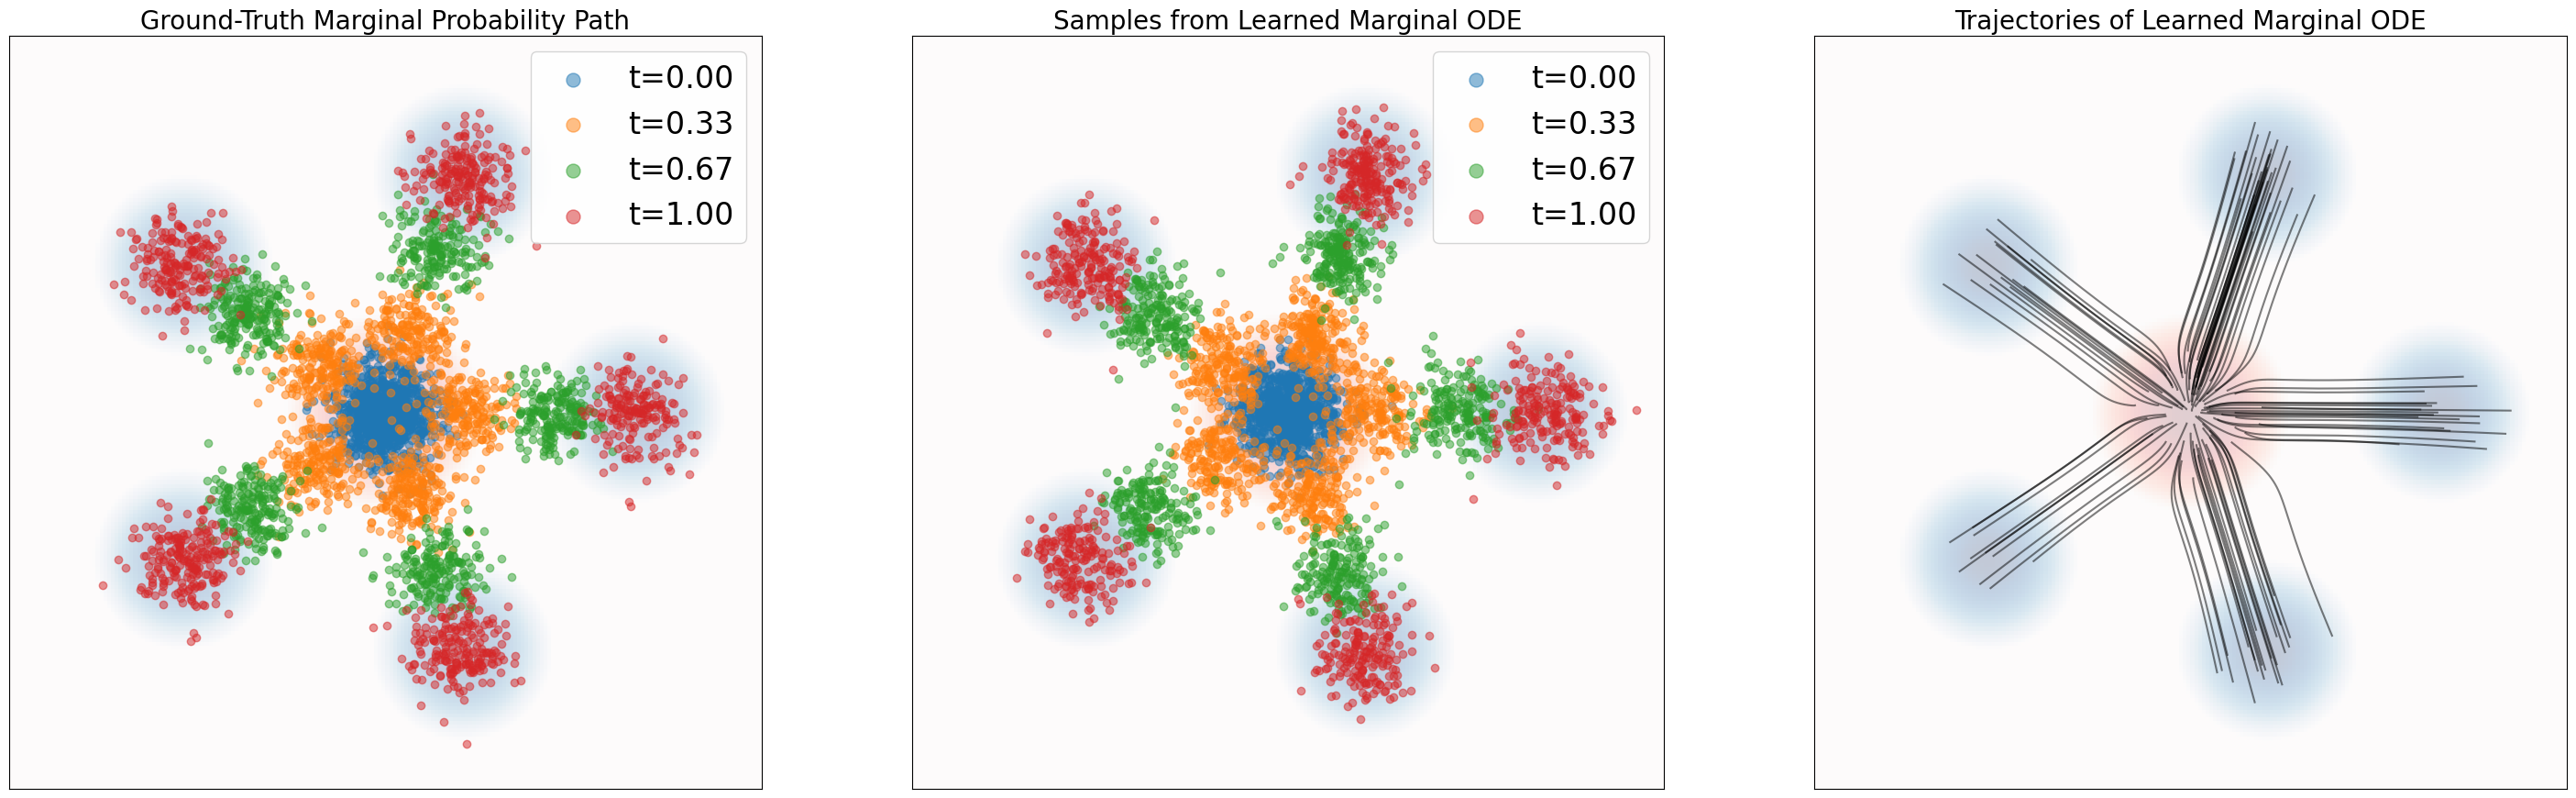

In [21]:
#######################
# Change these values #
#######################
num_samples = 1000
num_timesteps = 1000
num_marginals = 3


##############
# Setup Plot #
##############

scale = PARAMS["scale"]
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]
legend_size=24
markerscale=1.8

# Setup figure
fig, axes = plt.subplots(1,3, figsize=(36, 12))

###########################################
# Graph Samples from Learned Marginal ODE #
###########################################
ax = axes[1]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Samples from Learned Marginal ODE", fontsize=20)

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))


# Construct integrator and plot trajectories
ode = LearnedVectorFieldODE(flow_model)
simulator = EulerSimulator(ode)
x0 = path.p_simple.sample(num_samples) # (num_samples, 2)
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)
xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)
for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].item()
    ax.scatter(xts_every_n[:,plot_idx,0].detach().cpu(), xts_every_n[:,plot_idx,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')

ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

##############################################
# Graph Trajectories of Learned Marginal ODE #
##############################################
ax = axes[2]
ax.set_title("Trajectories of Learned Marginal ODE", fontsize=20)
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

for traj_idx in range(num_samples // 10):
    ax.plot(xts[traj_idx,:,0].detach().cpu(), xts[traj_idx,:,1].detach().cpu(), alpha=0.5, color='black')

################################################
# Graph Ground-Truth Marginal Probability Path #
################################################
ax = axes[0]
ax.set_title("Ground-Truth Marginal Probability Path", fontsize=20)
ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])

for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].unsqueeze(0).expand(num_samples, 1)
    marginal_samples = path.sample_marginal_path(tt)
    ax.scatter(marginal_samples[:,0].detach().cpu(), marginal_samples[:,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt[0,0].item():.2f}')

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

plt.show()